In [1]:
import pickle
from typing import Optional
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gurobipy import GRB
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from plots import *
from ems_data import *
from simulation import *
from dataset import *
from linear_model import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 4
TIME_LIMIT = 60  # Just for testing

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str, metric_short: Optional[str] = None):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(metric)
    if metric_short is not None:
        metric = metric_short
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [2]:
N_AMBULANCES = 50  # 43, 50, 57

region_id = 1
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
n_stations = len(ems_data.stations)
print(f"# stations: {n_stations}")
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
X = dataset.drop(columns=METRICS).to_numpy()
Y = dataset[METRICS].to_numpy()

# for metric in METRICS:
#     y = Y[:, METRICS.index(metric)]
#     plot_metric(X, y, metric)

# stations: 46


In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [43, 50, 57]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_9min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_9min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {43: 0.5378511773938689, 50: 0.4369429489820591, 57: 0.3874100103626275}
SERVICE_RATE = {43: 22.94662688807342, 50: 23.824098402950032, 57: 24.11136495764099}


# Cov9

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Coverage (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Coverage (transformed)'>],
       dtype=object))

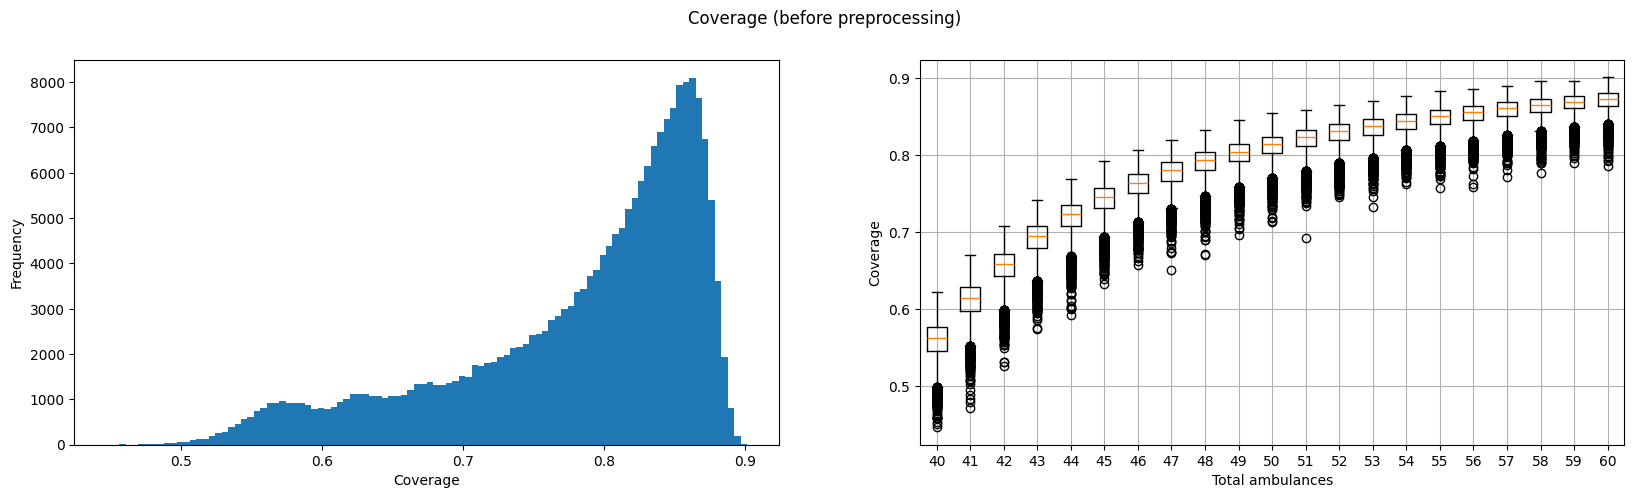

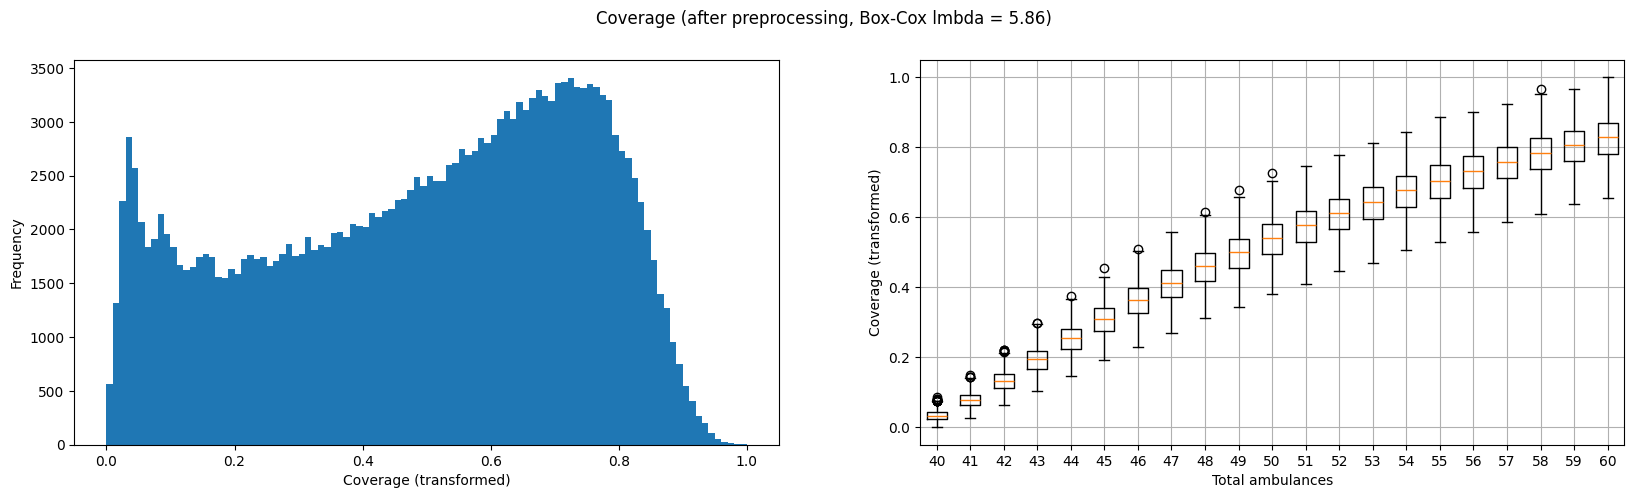

In [4]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.coverage_9min.to_numpy()
plot_metric(X, y, "Coverage (before preprocessing)", "Coverage")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Coverage (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Coverage (transformed)")

In [5]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/toronto_coverage_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [6]:
with open('trained_ml_models/toronto_coverage_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
(184,) (46, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 140 rows, 185 columns and 645 nonzeros
Model fingerprint: 0xa94bf48a
Variable types: 1 continuous, 184 integer (184 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 5e+01]
Found heuristic solution: objective -1.8523878
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 139 rows, 184 columns, 460 nonzeros
Variable types: 0 continuous, 184 integer (184 binary)
Found heuristic solution: objective 0.3684258

Root relaxation: objective 7.390293e-01, 1 iterations, 0.00 seconds (0.00 work uni

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.739173,0.951003,0.082218,5.710169,4.754205,10.272785,0.467303,22.926334
1,0.747042,0.955834,0.083274,5.608222,4.719998,10.048630,0.460105,23.097124
2,0.745022,0.953875,0.082947,5.646064,4.735235,10.099536,0.461580,23.013766
3,0.749237,0.955558,0.083276,5.597067,4.701441,10.003664,0.457511,23.043049
4,0.747371,0.954571,0.083078,5.618147,4.703869,9.997953,0.461117,23.073372


In [7]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/toronto_coverage_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [8]:
with open('trained_ml_models/toronto_coverage_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15248 rows, 10212 columns and 40701 nonzeros
Model fingerprint: 0x8af3d7a7
Variable types: 5084 continuous, 5128 integer (5082 binary)
Coefficient statistics:
  Matrix range     [3e-02, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 5e+01]
Found heuristic solution: objective 0.0539718
Presolve removed 3188 rows and 3165 columns
Presolve time: 0.33s
Presolved: 12060 rows, 7047 columns, 65753 nonzeros
Variable types: 0 continuous, 7047 integer (7001 binary)

Root relaxation: objective 9.074874e-01, 3035 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Obj

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.726277,0.970833,0.075052,5.844896,5.276706,9.482669,0.461469,22.968450
1,0.722422,0.969516,0.074824,5.883481,5.280895,9.611131,0.467513,22.806707
2,0.724523,0.970768,0.075149,5.847777,5.273861,9.513816,0.461469,23.039648
3,0.714714,0.965968,0.074325,5.952015,5.329006,9.736328,0.467548,22.940631
4,0.717846,0.968783,0.074502,5.904176,5.314875,9.613656,0.465894,22.895752


In [5]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_coverage'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 52%|█████▏    | 52/100 [02:59<02:46,  3.46s/epoch, best_val_loss=7.47e-5, train_loss=8.25e-5, val_loss=7.93e-5]  


Early stopping


100%|██████████| 100/100 [05:19<00:00,  3.20s/epoch, best_val_loss=5.11e-5, train_loss=5.01e-5, val_loss=5.11e-5]


In [10]:
weights, biases = MLP.load_npz('trained_ml_models/toronto_coverage.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4077 rows, 3094 columns and 55169 nonzeros
Model fingerprint: 0x2cacd29d
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [8e-07, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [9e-04, 5e+01]
Found heuristic solution: objective -1.0463378
Presolve removed 118 rows and 89 columns
Presolve time: 0.04s
Presolved: 3959 rows, 3005 columns, 53954 nonzeros
Variable types: 1973 continuous, 1032 integer (986 binary)

Root relaxation: objective 5.401988e+00, 1663 iterations, 0.16 seconds (0.32 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.852663,0.991587,0.092630,4.701915,4.304743,7.558455,0.443652,23.940885
1,0.848059,0.989697,0.092357,4.745188,4.332678,7.626688,0.445304,23.827894
2,0.849817,0.990926,0.092476,4.714320,4.328604,7.552394,0.440702,23.946569
3,0.851358,0.990969,0.092399,4.716290,4.317845,7.557595,0.444348,23.911579
4,0.851171,0.990402,0.092516,4.723041,4.323883,7.560325,0.447231,23.841609


# SurvRate

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Survival rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Survival rate (transformed)'>],
       dtype=object))

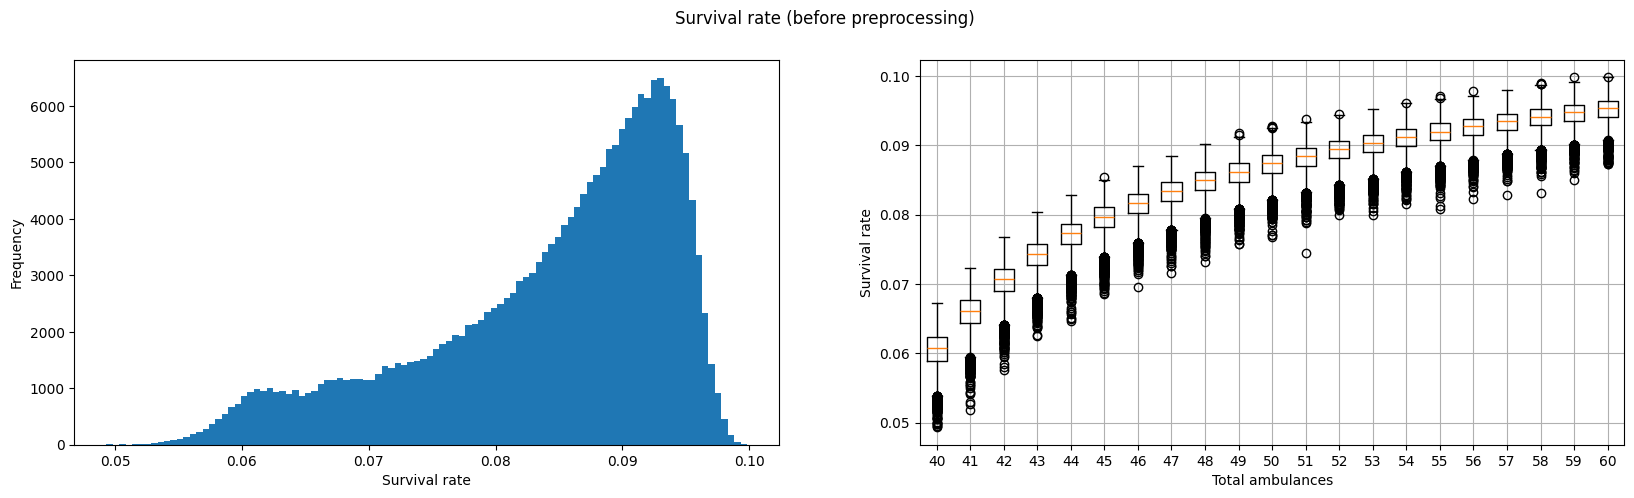

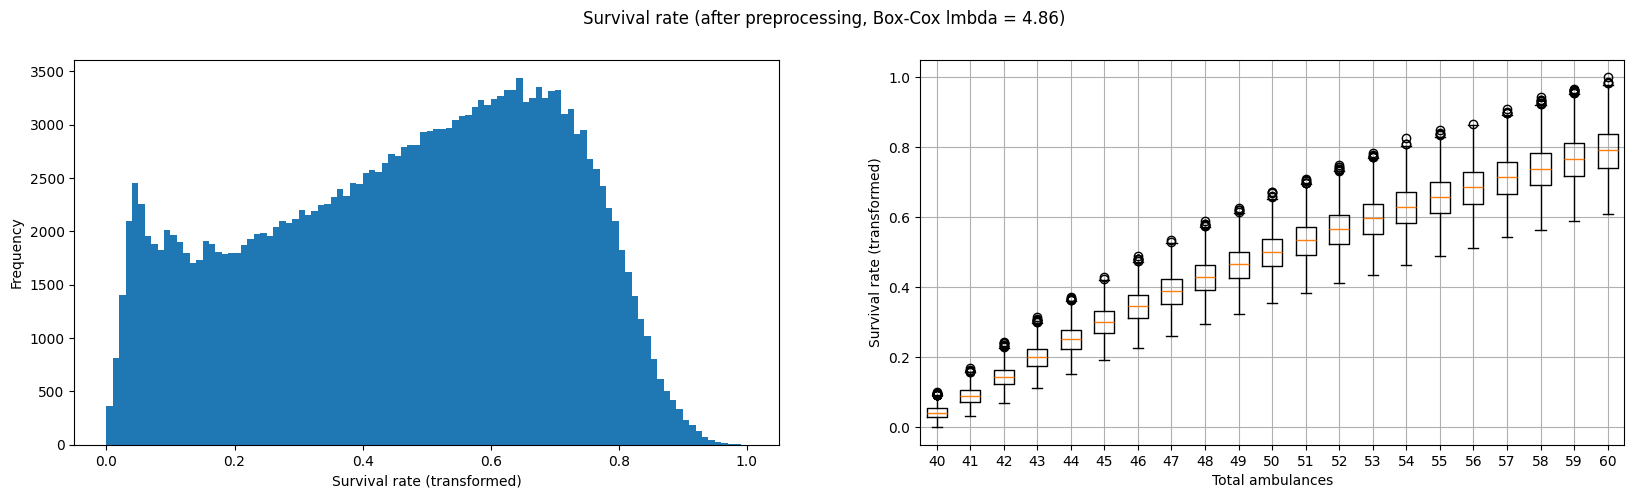

In [11]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.survival_rate.to_numpy()
plot_metric(X, y, "Survival rate (before preprocessing)", "Survival rate")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Survival rate (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Survival rate (transformed)")

In [12]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/toronto_survival_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [13]:
with open('trained_ml_models/toronto_survival_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(184,) (46, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 140 rows, 185 columns and 645 nonzeros
Model fingerprint: 0xec6c5d31
Variable types: 1 continuous, 184 integer (184 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 5e+01]
Found heuristic solution: objective -1.7497471
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 139 rows, 184 columns, 460 nonzeros
Variable types: 0 continuous, 184 integer (184 binary)
Found heuristic solution: objective 0.3266009

Root relaxation: objective 7.270652e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.783612,0.972078,0.087680,5.215662,4.480916,9.145193,0.452181,23.466430
1,0.785338,0.970524,0.088083,5.207655,4.476549,9.075328,0.449760,23.433199
2,0.786983,0.971782,0.088231,5.195843,4.459280,9.089098,0.451578,23.340949
3,0.780350,0.971584,0.087531,5.233622,4.504850,9.175128,0.456127,23.391733
4,0.784345,0.970852,0.087852,5.219174,4.498844,9.134742,0.453830,23.344379


In [14]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/toronto_survival_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [15]:
with open('trained_ml_models/toronto_survival_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13529 rows, 9066 columns and 36116 nonzeros
Model fingerprint: 0x12da8176
Variable types: 4511 continuous, 4555 integer (4509 binary)
Coefficient statistics:
  Matrix range     [5e-02, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 5e+01]
Found heuristic solution: objective 0.0533941
Presolve removed 2834 rows and 2811 columns
Presolve time: 0.28s
Presolved: 10695 rows, 6255 columns, 58279 nonzeros
Variable types: 0 continuous, 6255 integer (6209 binary)

Root relaxation: objective 8.557381e-01, 2736 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Obje

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.618309,0.940648,0.065461,6.725491,5.979017,11.242617,0.478694,22.168677
1,0.618900,0.938943,0.065516,6.753118,5.958782,11.320385,0.480115,22.146344
2,0.624740,0.940920,0.065958,6.676855,5.931644,11.167023,0.477810,22.129802
3,0.618934,0.940806,0.065748,6.711942,5.973431,11.236533,0.478757,22.162234
4,0.618915,0.939905,0.065525,6.731145,5.971703,11.264361,0.481802,22.128307


In [9]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_survival'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 64%|██████▍   | 64/100 [04:09<02:20,  3.90s/epoch, best_val_loss=0.000398, train_loss=0.0013, val_loss=0.000492] 


Early stopping


 91%|█████████ | 91/100 [05:46<00:34,  3.81s/epoch, best_val_loss=7.44e-5, train_loss=7.84e-5, val_loss=0.000101]  


Early stopping


100%|██████████| 100/100 [05:46<00:00,  3.46s/epoch, best_val_loss=4.65e-5, train_loss=4.54e-5, val_loss=4.65e-5]


In [18]:
weights, biases = MLP.load_npz('trained_ml_models/toronto_survival.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4071 rows, 3094 columns and 55163 nonzeros
Model fingerprint: 0xbed49792
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [4e-07, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-03, 5e+01]
Presolve removed 103 rows and 79 columns
Presolve time: 0.04s
Presolved: 3968 rows, 3015 columns, 53974 nonzeros
Variable types: 1980 continuous, 1035 integer (989 binary)

Root relaxation: objective 5.670805e+00, 1712 iterations, 0.20 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.67081    0  462          -    5.67081 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.852795,0.989904,0.094135,4.660141,4.228215,7.572549,0.446581,23.896286
1,0.859582,0.990014,0.094418,4.631747,4.221379,7.461864,0.443629,23.960068
2,0.853991,0.989552,0.093862,4.664894,4.244768,7.538782,0.446584,23.820823
3,0.853241,0.989715,0.093644,4.680958,4.257358,7.567441,0.449250,23.753654
4,0.857680,0.990006,0.094261,4.637319,4.224597,7.485243,0.444029,23.956546


# RTMean

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean response time (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Mean response time (transformed)'>],
       dtype=object))

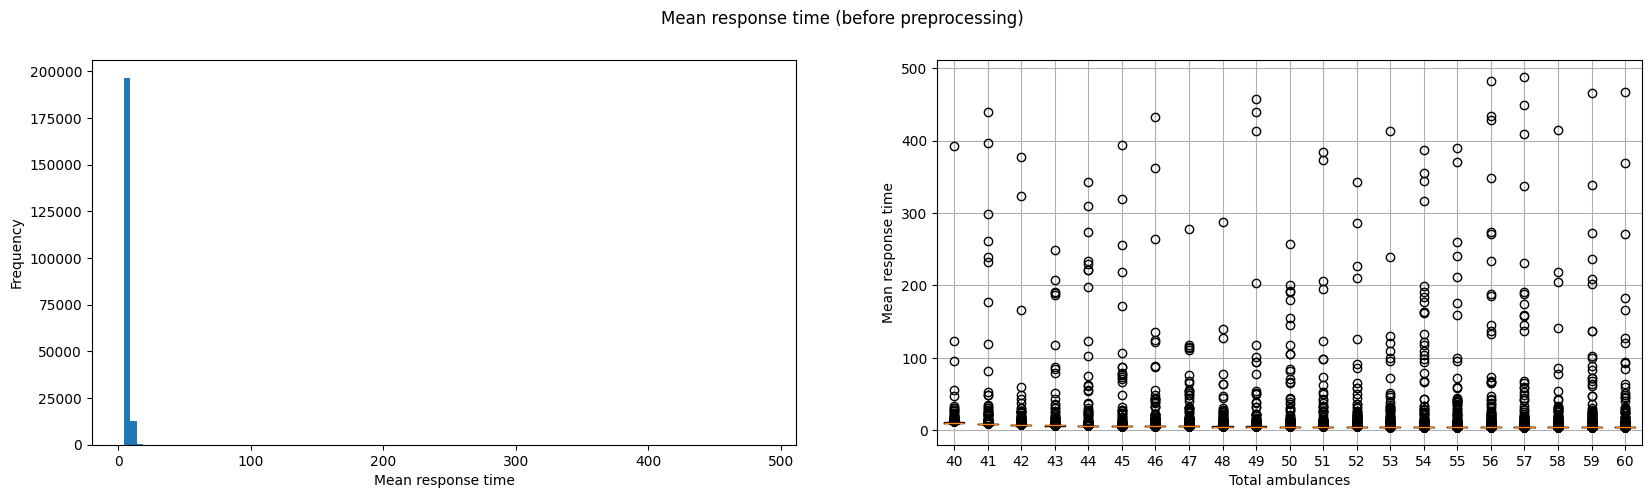

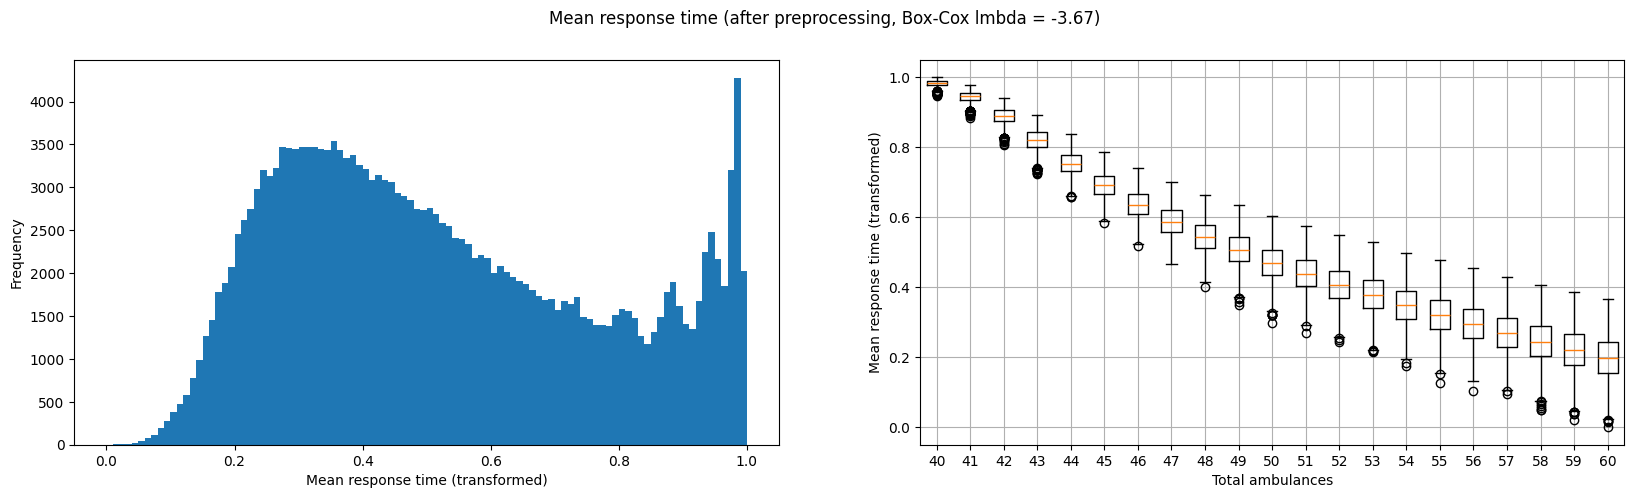

In [19]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.response_time_mean.to_numpy()
plot_metric(X, y, "Mean response time (before preprocessing)", "Mean response time")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Mean response time (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Mean response time (transformed)")

In [20]:
X_new = binarize_solutions(X)
ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5)
ridge.fit(X_new, y)
with open('trained_ml_models/toronto_median_linear.pkl', 'wb') as f:
    pickle.dump(ridge, f)

In [21]:
with open('trained_ml_models/toronto_median_linear.pkl', 'rb') as f:
    ridge = pickle.load(f)
solution, model = linear_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    coef=keep_relevant_coefficients(ridge.coef_, n_stations, FACILITY_CAPACITY),
    intercept=ridge.intercept_,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
(184,) (46, 4)
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 140 rows, 185 columns and 645 nonzeros
Model fingerprint: 0x174a9520
Variable types: 1 continuous, 184 integer (184 binary)
Coefficient statistics:
  Matrix range     [5e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 5e+01]
Found heuristic solution: objective 2.8108819
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 139 rows, 184 columns, 460 nonzeros
Variable types: 0 continuous, 184 integer (184 binary)
Found heuristic solution: objective 0.6430239

Root relaxation: objective 3.035264e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.772985,0.964751,0.085841,5.365866,4.566784,9.480175,0.461194,23.200243
1,0.772114,0.965749,0.085970,5.366764,4.563354,9.466459,0.457000,23.259502
2,0.775169,0.964366,0.085988,5.374552,4.582664,9.472270,0.457428,23.300626
3,0.771763,0.965310,0.085933,5.382833,4.595710,9.483773,0.459523,23.283642
4,0.772600,0.965746,0.085899,5.361903,4.594626,9.390954,0.456530,23.345683


In [22]:
model = DecisionTreeRegressor()
grid_search = GridSearchCV(model, {'min_samples_split': [80, 90, 100, 110, 120]}, cv=5)
grid_search.fit(X, y)
dt = grid_search.best_estimator_
with open('trained_ml_models/toronto_median_dt.pkl', 'wb') as f:
    pickle.dump(dt, f)

In [23]:
with open('trained_ml_models/toronto_median_dt.pkl', 'rb') as f:
    dt = pickle.load(f)
solution, model = dt_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    dt=dt,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 11174 rows, 7496 columns and 29834 nonzeros
Model fingerprint: 0x1723a65b
Variable types: 3726 continuous, 3770 integer (3724 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [4e+00, 5e+01]
Found heuristic solution: objective 0.9757733
Presolve removed 2362 rows and 2327 columns
Presolve time: 0.23s
Presolved: 8812 rows, 5169 columns, 48110 nonzeros
Variable types: 0 continuous, 5169 integer (5123 binary)

Root relaxation: objective 1.151381e-01, 1307 iterations, 0.11 seconds (0.26 work units)

    Nodes    |    Current Node    |     Objec

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.000132,0.000282,0.000017,75344.716591,75089.439562,136444.647558,0.999705,18.499038
1,0.000339,0.000866,0.000043,75900.252060,76082.903575,136316.026007,0.999708,18.461730
2,0.000094,0.000282,0.000013,76247.869651,76287.809489,137397.744604,0.999784,18.431498
3,0.000075,0.000168,0.000009,76670.622053,76787.984622,138125.478736,0.999735,18.482919
4,0.000151,0.000245,0.000016,75442.200048,75353.379583,136162.356564,0.999709,18.455635


In [13]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='toronto_median'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 34%|███▍      | 34/100 [02:04<04:02,  3.67s/epoch, best_val_loss=0.000488, train_loss=0.00172, val_loss=0.000724]


Early stopping


 73%|███████▎  | 73/100 [04:14<01:34,  3.49s/epoch, best_val_loss=0.000114, train_loss=0.000119, val_loss=0.000114]

Early stopping


In [27]:
weights, biases = MLP.load_npz('trained_ml_models/toronto_median.npz')
solution, model = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Solution: {solution.tolist()}\nTotal ambulances used: {sum(solution)}\nRuntime: {model.Runtime}\nMIPGap: {model.MIPGap}\nObjVal: {model.objVal}\nObjBound: {model.objBound}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4059 rows, 3094 columns and 55151 nonzeros
Model fingerprint: 0x41022b2d
Variable types: 2048 continuous, 1046 integer (1000 binary)
Coefficient statistics:
  Matrix range     [6e-07, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-05, 5e+01]
Found heuristic solution: objective 2.7974137
Presolve removed 73 rows and 63 columns
Presolve time: 0.04s
Presolved: 3986 rows, 3031 columns, 54006 nonzeros
Variable types: 1990 continuous, 1041 integer (995 binary)

Root relaxation: objective -7.299895e+00, 1668 iterations, 0.15 seconds (0.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.843958,0.990191,0.091523,4.774385,4.363394,7.683785,0.448207,23.778224
1,0.847568,0.990109,0.091842,4.753542,4.355638,7.628892,0.442226,23.902152
2,0.844699,0.989168,0.091594,4.788587,4.372468,7.678263,0.448306,23.834937
3,0.845873,0.990245,0.091646,4.759316,4.356409,7.613663,0.445563,23.825740
4,0.847146,0.989361,0.091423,4.777791,4.354591,7.611988,0.447477,23.765731
